# MNIST for online classification

In [44]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import jax
import keras
import optax
import numpy as np
import pandas as pd
import flax.linen as nn
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
from functools import partial
from jax.flatten_util import ravel_pytree

from rebayes_mini.methods import low_rank_filter_revised as lrkf
from rebayes_mini.methods import low_rank_last_layer as flores

In [47]:
sns.set_palette("colorblind")

In [48]:
%config InlineBackend.figure_format = "retina"

## Load dataset

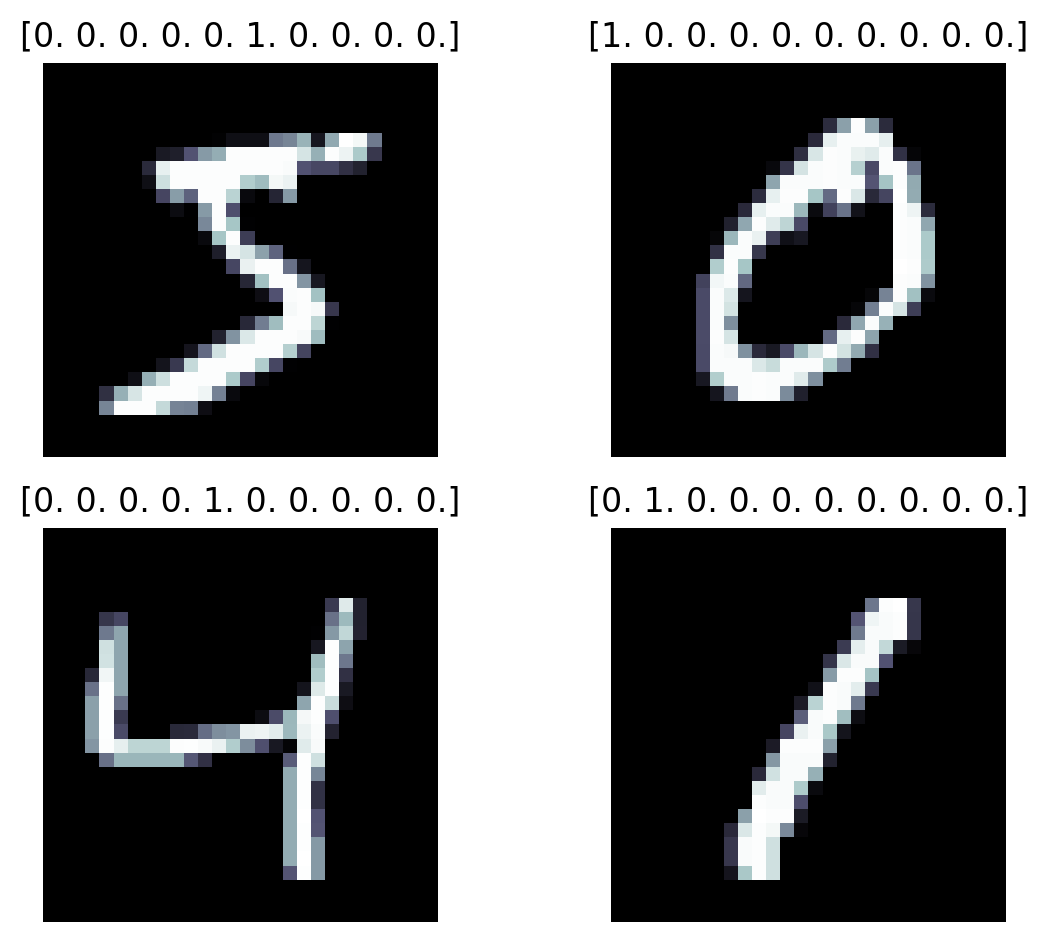

In [50]:
# (X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
# X_train = einops.rearrange(X_train, "s w h -> s (w h)") / 255
# X_test = einops.rearrange(X_test, "s w h -> s (w h)") / 255
X_train = X_train[..., None] / 255
X_test = X_test[..., None] / 255
y_train = jax.nn.one_hot(y_train, 10)
X_train = jnp.array(X_train)
fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(axs.ravel()):
    ax.imshow(X_train[i], cmap="bone")
    ax.set_title(y_train[i])
    ax.axis("off")
plt.tight_layout()

## Train

In [51]:
X_eval = X_test[:5_000]
y_eval = y_test[:5_000]

In [52]:
class CNN(nn.Module):
    num_arms: int = 10

    @nn.compact
    def __call__(self, x):
        x = x if len(x.shape) > 3 else x[None, :]
        x = nn.Conv(features=6, kernel_size=(5, 5))(x)
        x = nn.elu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = nn.Conv(features=16, kernel_size=(5, 5), padding="VALID")(x)
        x = nn.elu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=120)(x)
        x = nn.elu(x)
        x = nn.Dense(features=84)(x)
        x = nn.elu(x)
        x = nn.Dense(10, name="last_layer")(x)
        return x.squeeze()

model = CNN()

In [60]:
def plot_err_bound(df, ax, label, periods=5000, min_periods=None):
    min_periods = periods if min_periods is None else min_periods
    df.rolling(periods, min_periods=min_periods).mean().mean(axis=1).plot(label=label, ax=ax)

## Revised version

In [53]:
def callbackfn(bel_update, bel_pred, y, x, agent):
    """
    Compute test accuracy at every timestep
    """
    yhat = agent.predict_fn(bel_pred, x)
    acc = y.argmax() == yhat.argmax()
    return acc, bel_update.epull, bel_update.econs

In [54]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    return jax.nn.softmax(eta)

def cov_fn(mean, eps=0.1):
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [55]:
n_sims = 1
keys = jax.random.PRNGKey(314)
keys = jax.random.split(keys, n_sims)
model = CNN()

In [56]:
n_obs = len(X_train)

In [73]:
%%time

def run_lrkf(key, rank=20):
    key_init, key_shuffle = jax.random.split(key)
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    
    params = model.init(key_init, X_train[:1])
    agent = lrkf.LowRankCovarianceFilter(
        mean_fn,
        cov_fn,
        dynamics_covariance=0.01,
        rank=rank,
    )
    bel_init = agent.init_bel(params, cov=1.0, low_rank_diag=True)
    print(bel_init.mean.shape)
    
    cfn = partial(callbackfn, agent=agent)
    bel, hist_lrkf = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    return hist_lrkf

hist_lrkf = jax.vmap(run_lrkf)(keys)
hist_lrk = jax.tree.map(np.array, hist_lrkf)

(61706,)
CPU times: user 10.1 s, sys: 0 ns, total: 10.1 s
Wall time: 46.7 s


In [74]:
df_lrkf = pd.DataFrame(hist_lrkf[0].T)
df_lrkf.shape

(60000, 1)

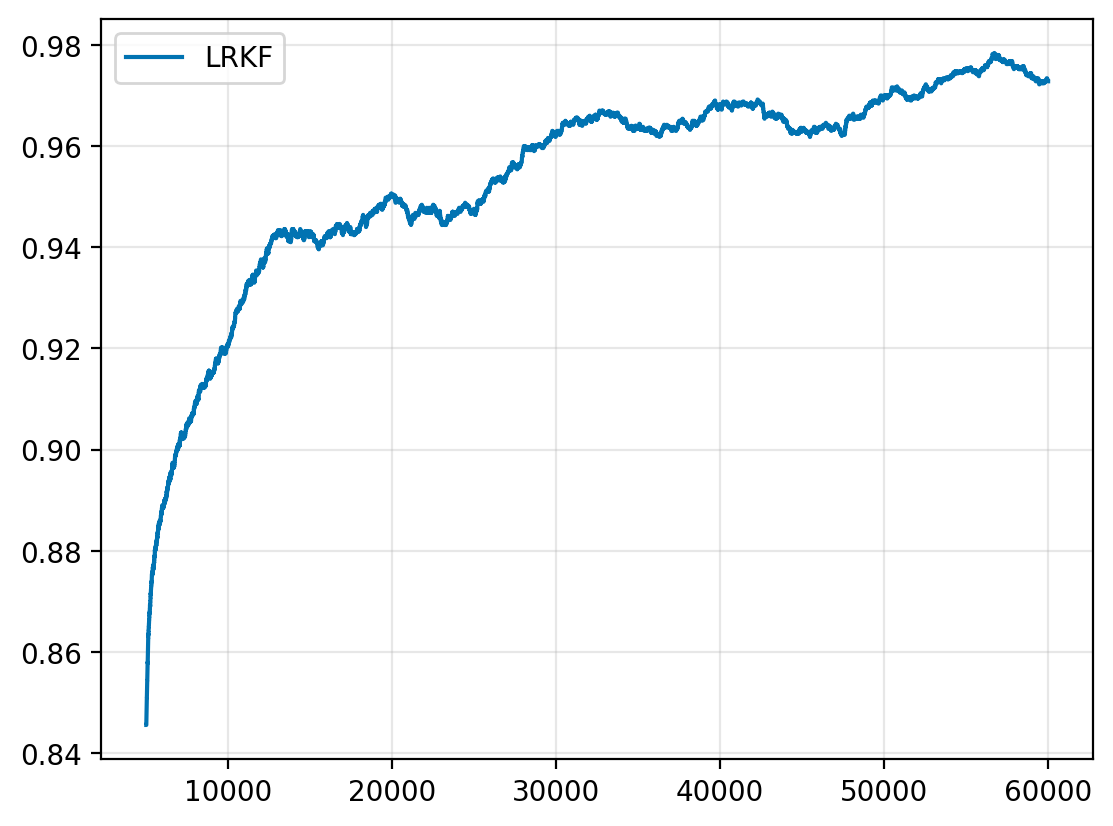

In [75]:
fig, ax = plt.subplots()
plot_err_bound(df_lrkf, ax, "LRKF")
plt.legend()
plt.grid(alpha=0.3)

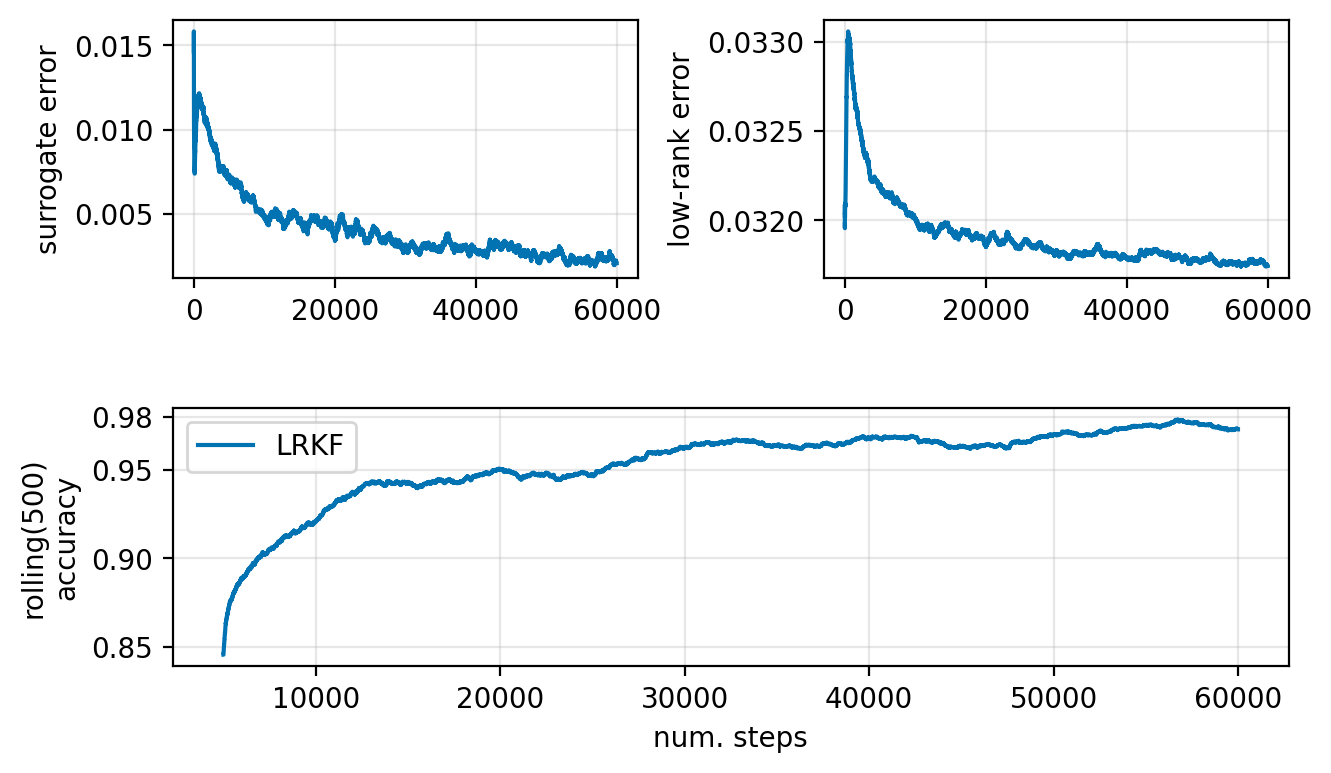

In [129]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(2, 2, hspace=0.5, wspace=0.4)
fig = plt.figure(figsize=(7.2, 4.2 ))

ax1 = fig.add_subplot(gs[0])
plt.sca(ax1)
pd.Series(np.array(hist_lrkf[1].ravel())).ewm(span=1000).mean().plot(ax=ax1)
plt.ylabel("surrogate error")
plt.grid(alpha=0.3)

ax2 = fig.add_subplot(gs[1])
plt.sca(ax2)
pd.Series(np.array(hist_lrkf[2].ravel())).ewm(span=1000).mean().plot(ax=ax2)
plt.ylabel("low-rank error")
plt.grid(alpha=0.3)

ax3 = fig.add_subplot(gs[2:])
plt.sca(ax3)
plot_err_bound(df_lrkf, ax3, "LRKF", min_periods=5000)
plt.legend()
plt.ylabel("rolling(500)\naccuracy")
plt.xlabel("num. steps")
plt.yticks([0.85, 0.90, 0.95, 0.98])
plt.grid(alpha=0.3)

plt.savefig("../figures/mnist-lrkf-error-analysis.png", dpi=300, bbox_inches="tight")

# LoLoFi

In [559]:
def callbackfn(bel_update, bel_pred, y, x, agent):
    """
    Compute test accuracy at every timestep
    """
    yhat = agent.predict_fn(bel_pred, x)
    acc = y.argmax() == yhat.argmax()
    return acc

In [560]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    return jax.nn.softmax(eta)

def cov_fn(mean, eps=1e-4):
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [561]:
%%time
def run_lolofi(key, rank=100):
    key_init, key_shuffle = jax.random.split(key)
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    
    agent = flores.LowRankLastLayer(
        mean_fn, cov_fn, rank=rank, rank_last=50,
        # dynamics_hidden=1e-6, dynamics_last=1e-6,
        dynamics_hidden=0.01, dynamics_last=0.01,
    )
    params = model.init(key, X_train[:100])
    
    bel_init = agent.init_bel(params, cov_hidden=1.0, cov_last=1.0, low_rank_diag=True)
    
    cfn = partial(callbackfn, agent=agent)
    bel_flores, hist_flores = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    
    return hist_flores

hist_lolofi = jax.vmap(run_lolofi)(keys)
hist_lolofi = jax.tree.map(np.array, hist_lolofi)

CPU times: user 50 s, sys: 998 ms, total: 51 s
Wall time: 15min 35s


In [562]:
df_lolofi = pd.DataFrame(hist_lolofi.T)
df_lolofi.shape

(50000, 1)

CPU times: user 50.8 ms, sys: 4.07 ms, total: 54.8 ms
Wall time: 54.7 ms


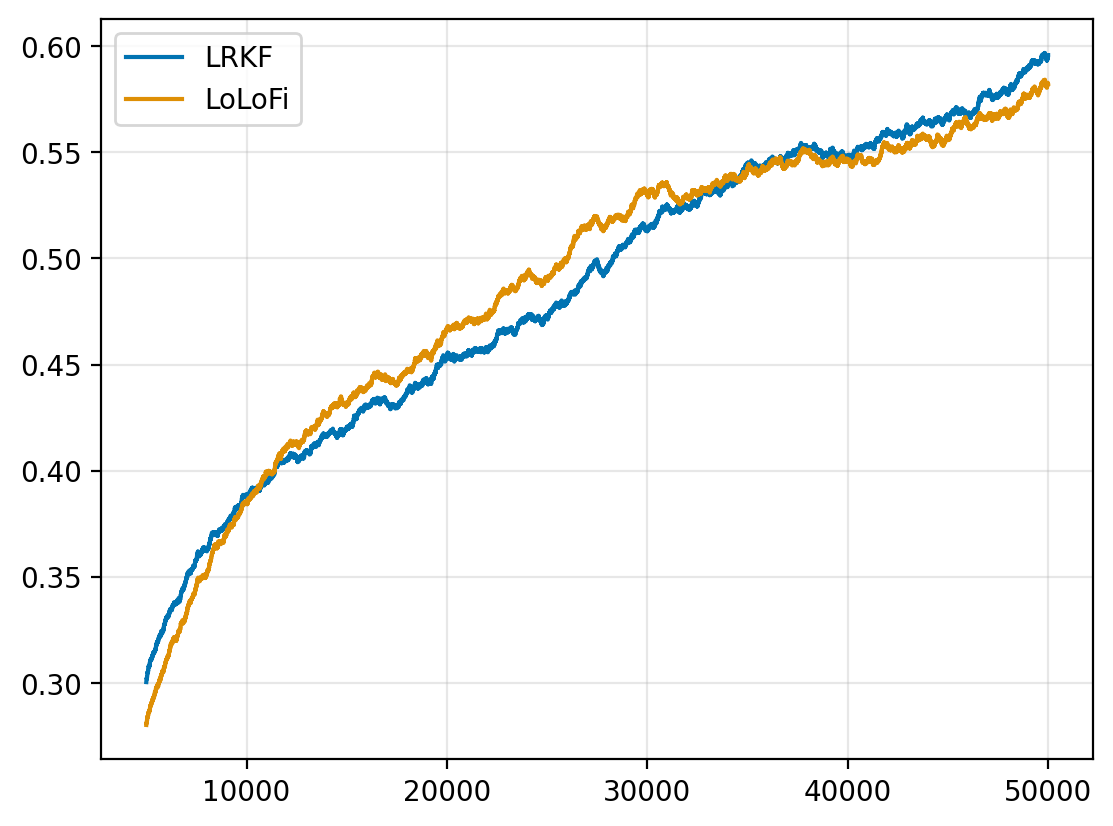

In [563]:
%%time
fig, ax = plt.subplots()
plot_err_bound(df_lrkf, ax, "LRKF")
plot_err_bound(df_lolofi, ax, "LoLoFi")
plt.legend()
plt.grid(alpha=0.3)

## HiLoFi

In [131]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    return jax.nn.softmax(eta)

def cov_fn(mean, eps=1e-4):
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [132]:
%%time
def run_hilofi(key, rank=50):
    key_init, key_shuffle = jax.random.split(key)
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    
    agent = flores.LowRankLastLayer(
        mean_fn, cov_fn, rank=rank, rank_last=None,
        # dynamics_hidden=1e-6, dynamics_last=1e-6,
        dynamics_hidden=0.01, dynamics_last=0.01,
    )
    params = model.init(key, X_train[:100])
    
    bel_init = agent.init_bel(params, cov_hidden=1.0, cov_last=1.0, low_rank_diag=True)
    
    cfn = partial(callbackfn, agent=agent)
    bel_flores, hist_flores = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    
    return hist_flores

hist_hilofi = jax.vmap(run_hilofi)(keys)
hist_hilofi = jax.tree.map(np.array, hist_hilofi)

CPU times: user 59.3 s, sys: 2.12 s, total: 1min 1s
Wall time: 12min 32s


In [133]:
df_hilofi = pd.DataFrame(hist_hilofi.T)
df_hilofi.shape

(60000, 10)

In [134]:
df_hilofi.mean()

0    0.952700
1    0.949350
2    0.947883
3    0.950267
4    0.948633
5    0.952117
6    0.955050
7    0.950950
8    0.953017
9    0.953133
dtype: float64

CPU times: user 117 ms, sys: 0 ns, total: 117 ms
Wall time: 117 ms


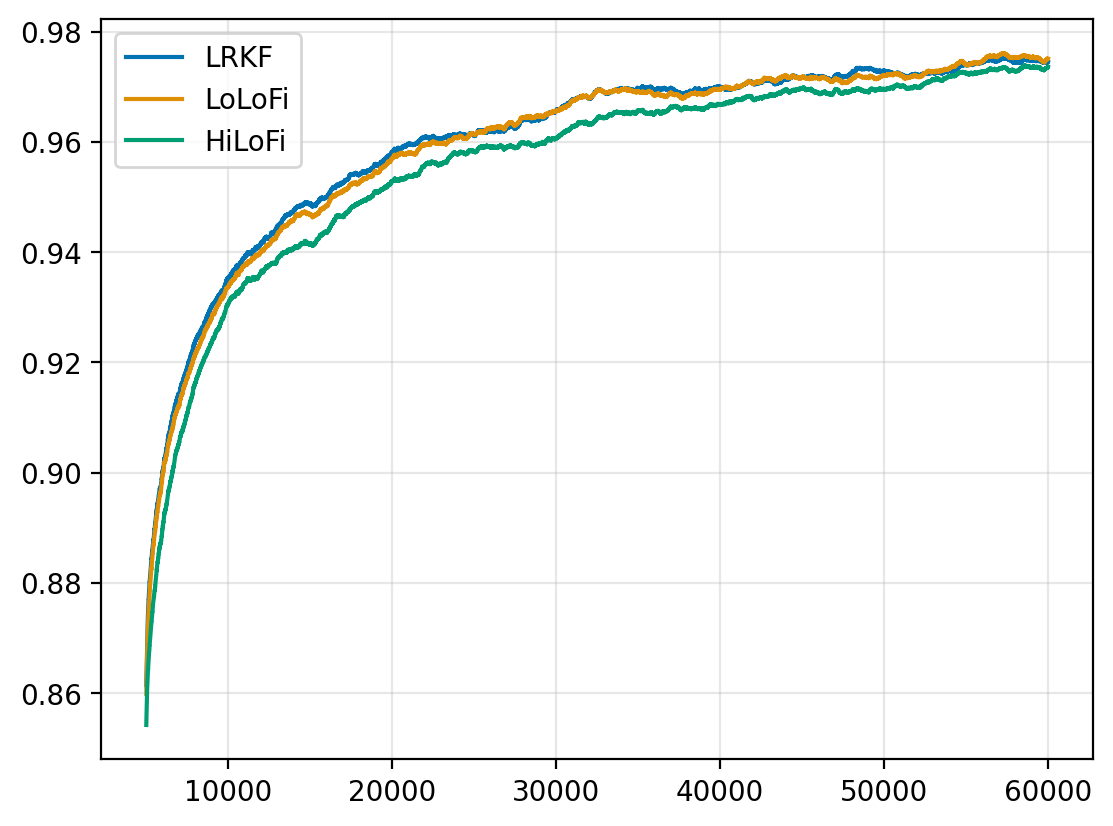

In [135]:
%%time
fig, ax = plt.subplots()
plot_err_bound(df_lrkf, ax, "LRKF")
plot_err_bound(df_lolofi, ax, "LoLoFi")
plot_err_bound(df_hilofi, ax, "HiLoFi")
plt.legend()
plt.grid(alpha=0.3)

## Low-rank (precision) filter (LoFi)

In [136]:
from rebayes_mini.methods import low_rank_filter as lofi

In [137]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    return jax.nn.softmax(eta)

def cov_fn(mean, eps=0.01):
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [138]:
%%time

def run_lofi(key, rank=50):
    key_init, key_shuffle = jax.random.split(key)
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    
    agent = lofi.LowRankPrecisionFilter(
        mean_fn, cov_fn, rank=rank, dynamics_covariance=0.0,
    )
    params = model.init(key_init, X_train[:100])
    
    bel_init = agent.init_bel(params, cov=jnp.exp(-8))
    
    cfn = partial(callbackfn, agent=agent)
    bel, hist_lofi = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    return hist_lofi

hist_lofi = jax.vmap(run_lofi)(keys)
hist_lofi = jax.tree.map(np.array, hist_lofi)

CPU times: user 40.6 s, sys: 753 ms, total: 41.4 s
Wall time: 6min 37s


In [139]:
df_lofi = pd.DataFrame(hist_lofi.T)
df_lofi.shape

(60000, 10)

CPU times: user 117 ms, sys: 0 ns, total: 117 ms
Wall time: 117 ms


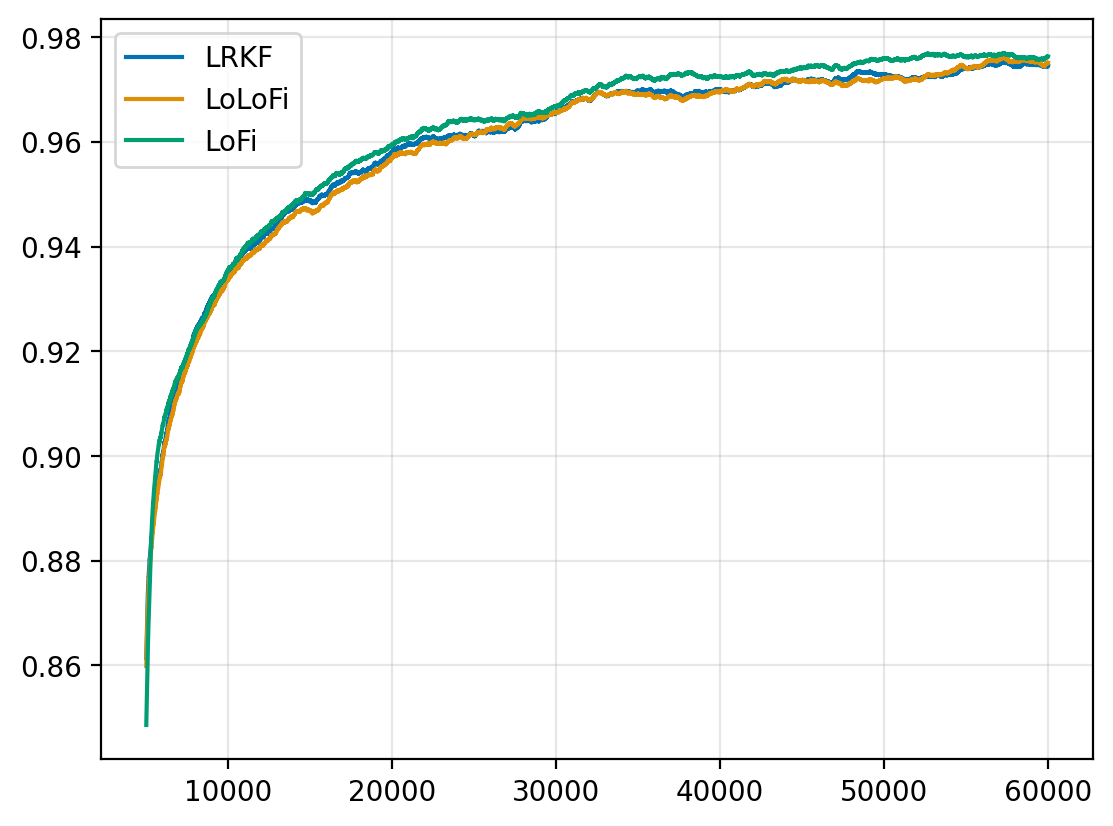

In [140]:
%%time
fig, ax = plt.subplots()
plot_err_bound(df_lrkf, ax, "LRKF")
plot_err_bound(df_lolofi, ax, "LoLoFi")
plot_err_bound(df_lofi, ax, "LoFi")
plt.legend()
plt.grid(alpha=0.3)

## Muon Shampoo

In [141]:
from rebayes_mini.methods import replay_sgd

In [144]:
def lossfn(params, counter, X, y, fn):
    yhat = fn(params, X)
    loss = optax.losses.softmax_cross_entropy(yhat, y)
    return (loss * counter).sum() / counter.sum()

In [145]:
%%time

def run_muon(key):
    key_init, key_shuffle = jax.random.split(key)
    
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    params = model.init(key_init, X_train[:100])
    
    agent = replay_sgd.FifoSGD(
        model.apply,
        lossfn,
        tx=optax.contrib.muon(learning_rate=1e-3),
        buffer_size=1,
        dim_features=(28, 28, 1),
        dim_output=10
    )
    
    cfn = partial(callbackfn, agent=agent)
    bel_init = agent.init_bel(params)
    bel_muon, hist_muon = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    return hist_muon

hist_muon = jax.vmap(run_muon)(keys)
hist_muon = jax.tree.map(np.array, hist_muon)

CPU times: user 13.9 s, sys: 158 ms, total: 14 s
Wall time: 31.5 s


In [146]:
df_muon = pd.DataFrame(hist_muon.T)
df_muon.shape

(60000, 10)

CPU times: user 177 ms, sys: 3.82 ms, total: 181 ms
Wall time: 181 ms


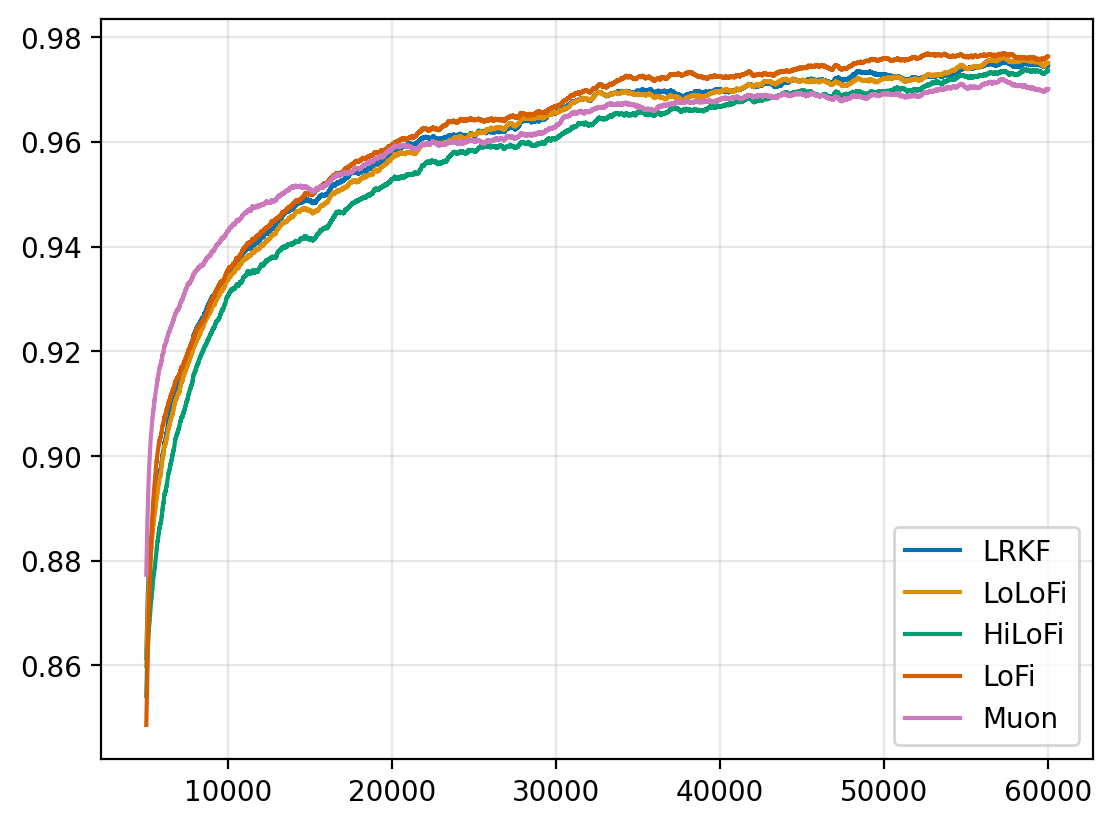

In [147]:
%%time
fig, ax = plt.subplots()
plot_err_bound(df_lrkf, ax, "LRKF")
plot_err_bound(df_lolofi, ax, "LoLoFi")
plot_err_bound(df_hilofi, ax, "HiLoFi")
plot_err_bound(df_lofi, ax, "LoFi")
plot_err_bound(df_muon, ax, "Muon")
plt.legend()
plt.grid(alpha=0.3)

## Adamw

In [148]:
%%time
def run_adamw(key):
    key_init, key_shuffle = jax.random.split(key)
    
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    params = model.init(key_init, X_train[:100])
    
    agent = replay_sgd.FifoSGD(
        model.apply,
        lossfn,
        tx=optax.adamw(learning_rate=1e-4),
        buffer_size=5,
        dim_features=(28, 28, 1),
        dim_output=10
    )
    
    cfn = partial(callbackfn, agent=agent)
    bel_init = agent.init_bel(params)
    bel, hist = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    return hist
    
hist_adamw = jax.vmap(run_adamw)(keys)
hist_adamw = jax.tree.map(np.array, hist_adamw)

CPU times: user 18.4 s, sys: 153 ms, total: 18.5 s
Wall time: 55.8 s


In [149]:
df_adamw = pd.DataFrame(hist_adamw.T)
df_adamw.shape

(60000, 10)

## Plot all results

In [154]:
def plot_err_bound(df, ax, label, periods=5000, min_periods=None):
    min_periods = periods if min_periods is None else min_periods
    df.rolling(periods, min_periods=min_periods).mean().mean(axis=1).plot(label=label, ax=ax)
    lbound = df.rolling(periods, min_periods=min_periods).mean().quantile(0.25, axis=1)
    ubound = df.rolling(periods, min_periods=min_periods).mean().quantile(0.75, axis=1)
    ax.fill_between(lbound.index, lbound, ubound, alpha=0.4)

CPU times: user 43.1 s, sys: 244 ms, total: 43.4 s
Wall time: 43.3 s


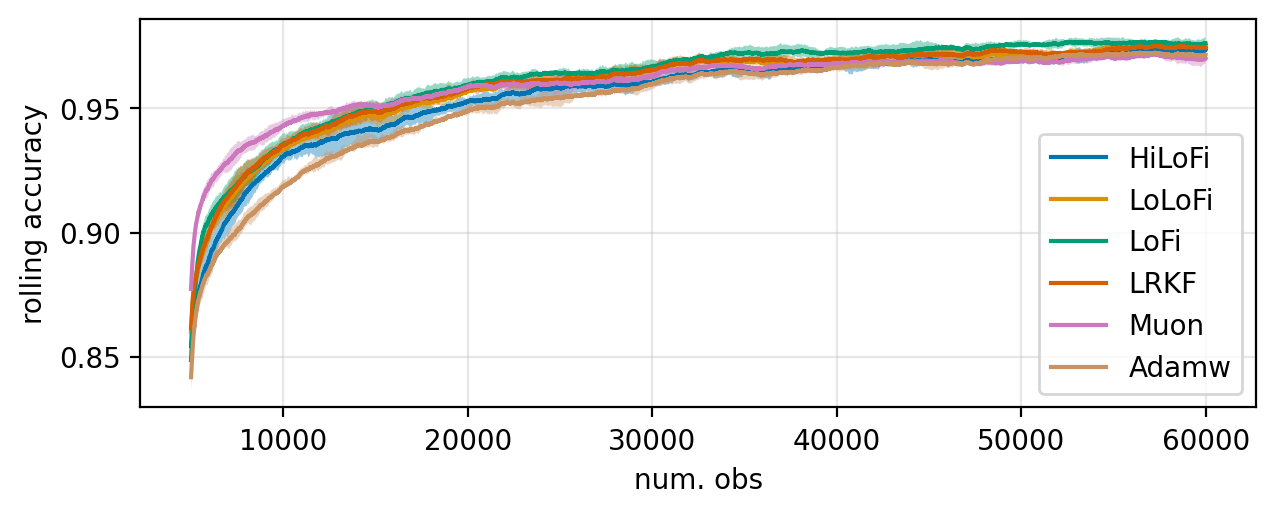

In [162]:
%%time
fig, ax = plt.subplots(figsize=(7.2, 4.2 * 0.6))
plot_err_bound(df_hilofi, ax, "HiLoFi")
plot_err_bound(df_lolofi, ax, "LoLoFi")
plot_err_bound(df_lofi, ax, "LoFi")
plot_err_bound(df_lrkf, ax, "LRKF")
plot_err_bound(df_adamw, ax, "Adamw")
plot_err_bound(df_muon, ax, "Muon")
plt.legend()
plt.ylabel("rolling accuracy")
plt.xlabel("num. obs")
plt.grid(alpha=0.3)
plt.savefig("../figures/mnist-online-classification.png", dpi=300, bbox_inches="tight")

# Plot results

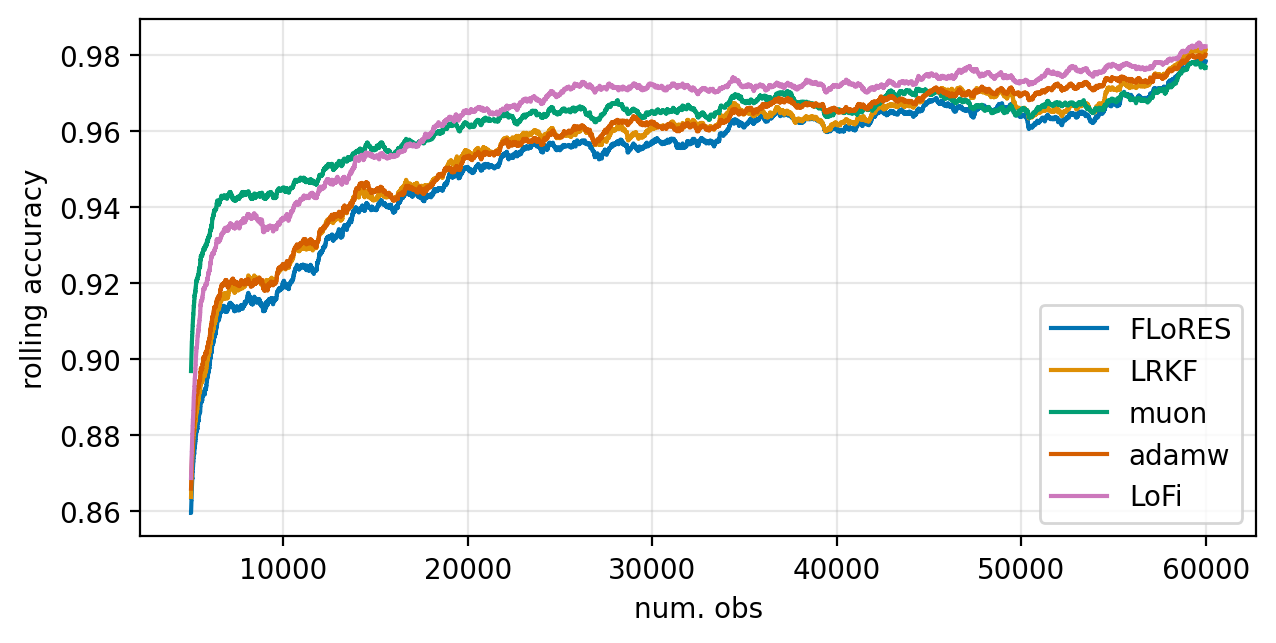

In [58]:
fig, ax = plt.subplots(figsize=(7.2, 4.2 * 0.8))


min_periods = 5000
pd.Series(hist_flores).rolling(5000, min_periods=min_periods).mean().plot(label="FLoRES")
pd.Series(hist_lrkf).rolling(5000, min_periods=min_periods).mean().plot(label="LRKF")
pd.Series(hist_muon).rolling(5000, min_periods=min_periods).mean().plot(label="muon")
pd.Series(hist_adamw).rolling(5000, min_periods=min_periods).mean().plot(label="adamw")
pd.Series(hist_lofi).rolling(5000, min_periods=min_periods).mean().plot(label="LoFi")
plt.grid(alpha=0.3)
plt.ylabel("rolling accuracy")
plt.xlabel("num. obs")
plt.legend()

## Multiple ranks

With constant full-rank inflation

In [183]:
key = jax.random.PRNGKey(3141)

In [204]:
%%time
ranks = [0, 1, 2, 5, 10, 20, 30, 50, 70, 100]
hist_all = {}
times_all = {}
params = model.init(key, X_train[:100])
for rank in ranks:
    print(rank, end="\r")

    agent = lrkf.LowRankCovarianceFilter(
        mean_fn,
        cov_fn,
        dynamics_covariance=0.01,
        rank=rank,
    )
    bel_init = agent.init_bel(params, cov=1.0, low_rank_diag=True)


    time_init = time()
    cfn = partial(callbackfn, agent=agent)
    bel, hist_lrkf = agent.scan(bel_init, y_train[:20_000], X_train[:20_000], cfn)
    hist_lrkf = np.array(hist_lrkf) * 1.0
    times_all[rank] = time() - time_init
    hist_all[rank] = hist_lrkf

hist_all = pd.DataFrame(hist_all)

CPU times: user 1min 46s, sys: 2.1 s, total: 1min 48s
Wall time: 2min 14s


In [205]:
times_all

{0: 10.78065299987793,
 1: 12.843039512634277,
 2: 12.167240142822266,
 5: 12.281671285629272,
 10: 12.493818759918213,
 20: 12.994854211807251,
 30: 13.339035511016846,
 50: 14.3035249710083,
 70: 15.146733283996582,
 100: 18.53090524673462}

In [206]:
colors = plt.cm.viridis(jnp.linspace(0, 1, len(ranks)))

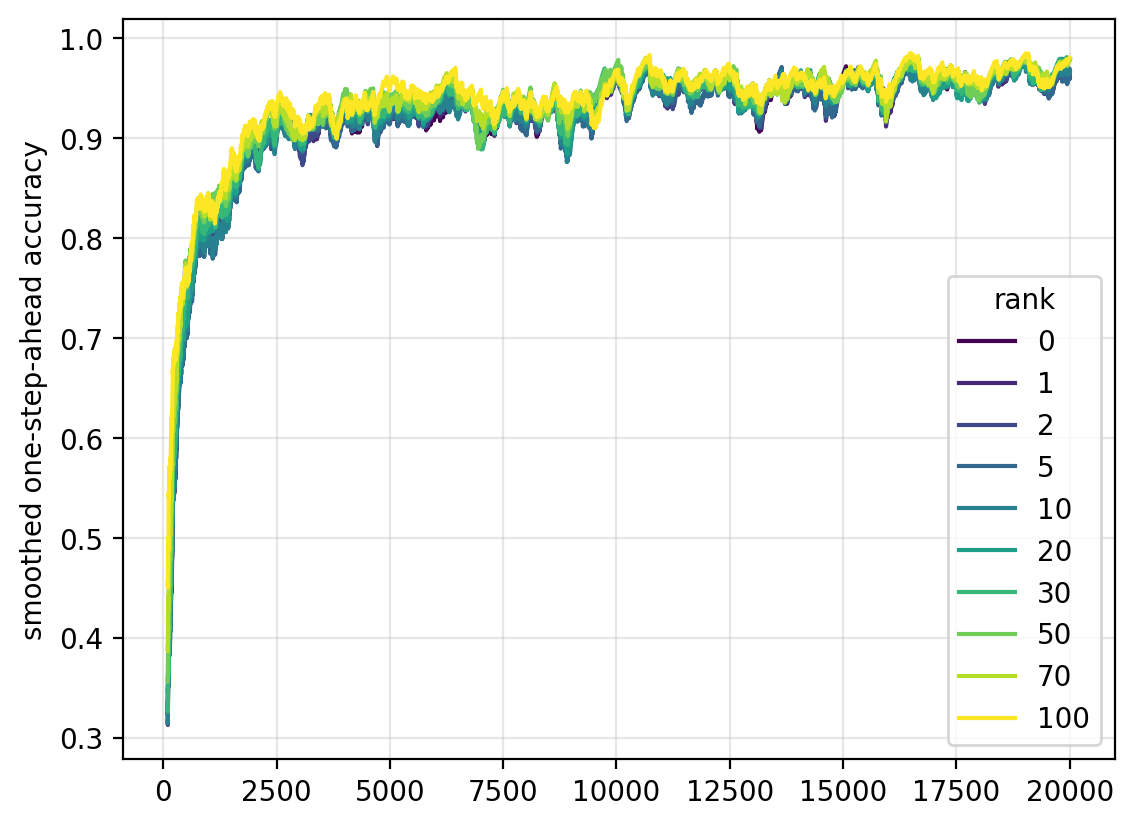

In [207]:
hist_all.ewm(min_periods=100, span=500).mean().plot(color=colors)
plt.ylabel("smoothed one-step-ahead accuracy")
plt.legend(title="rank")
plt.grid(alpha=0.3)

## Time / performance of LoFi / LRKF

In [93]:
key = jax.random.PRNGKey(314)

In [94]:
from tqdm import tqdm

In [114]:
ranks = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


result = []
for rank in tqdm(ranks):
    time_init = time()
    hist = run_lrkf(key, rank)
    hist = jax.tree.map(np.array, hist)
    time_end = time()
    running_time = time_end - time_init
    result.append({
        "method": "LRKF",
        "running_time": running_time,
        "accuracy": hist[5000:],
        "rank": rank,
    })

    time_init = time()
    hist = run_lofi(key, rank)
    hist = jax.tree.map(np.array, hist)
    time_end = time()
    running_time = time_end - time_init
    result.append({
        "method": "LoFi",
        "running_time": running_time,
        "accuracy": hist[5000:],
        "rank": rank,
    })


    time_init = time()
    hist = run_lolofi(key, rank)
    hist = jax.tree.map(np.array, hist)
    time_end = time()
    running_time = time_end - time_init
    result.append({
        "method": "LoLoFi",
        "running_time": running_time,
        "accuracy": hist[5000:],
        "rank": rank,
    })

    
    time_init = time()
    hist = run_hilofi(key, rank)
    hist = jax.tree.map(np.array, hist)
    time_end = time()
    running_time = time_end - time_init
    result.append({
        "method": "HiLoFi",
        "running_time": running_time,
        "accuracy": hist[5000:],
        "rank": rank,
    })

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [18:46<00:00, 93.84s/it]


In [115]:
df_result = pd.DataFrame(result)

df_result["accuracy"] = df_result["accuracy"].apply(lambda x: x[-10_000:].mean())

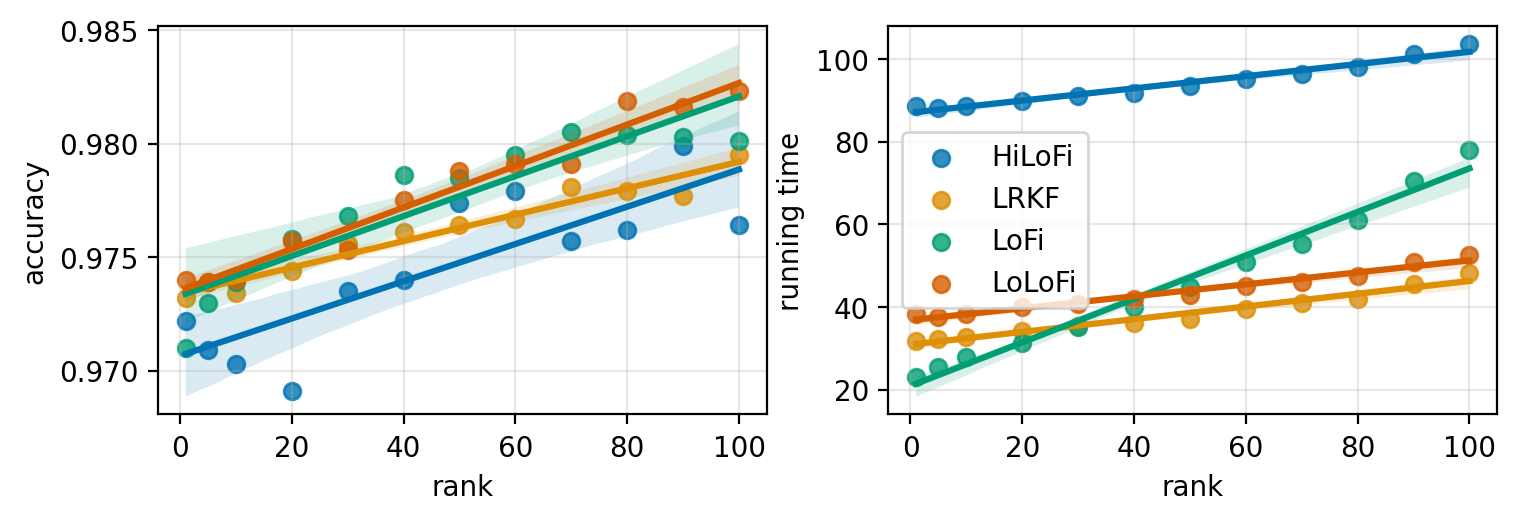

In [117]:
methods = df_result["method"].unique()
fig, axs = plt.subplots(1, 2, figsize=(7.2 * 1.2, 4.2 * 0.6))

plt.sca(axs[0])
for method in sorted(methods):
    sns.regplot(x="rank", y="accuracy", data=df_result.query("method == @method"), ax=axs[0], label=method)
axs[0].grid(alpha=0.3)
# plt.legend()

plt.sca(axs[1])
for method in sorted(methods):
    sns.regplot(x="rank", y="running_time", data=df_result.query("method == @method"), ax=axs[1], label=method)
axs[1].grid(alpha=0.3)
axs[1].legend()
axs[1].set_ylabel("running time")
plt.savefig("../figures/mnist-online-classification-rank-comparison.png", dpi=300, bbox_inches="tight")